# Feature Selection: Removing Redundant Features

**Objective:** Improve XGBoost performance by removing redundant features

**Strategy (Option A - Safe Removal):**
1. Identify highly correlated feature pairs (|r| > 0.9)
2. For each pair, remove the feature with LOWER importance
3. Keep the more important feature to preserve information
4. Retrain XGBoost on reduced feature set

**Current Status:**
- XGBoost baseline: **165 features, F1 = 82.70%**
- Redundant pairs detected: **124 pairs** (|r| > 0.9)
- Expected after removal: **85-105 features**

**Expected Improvements:**
- F1 Score: 82.70% → **83.5-84.5%** (+1-2%)
- Training time: **-30-40% faster**
- Generalization: **Better** (less overfitting)

---
## 1. Setup & Data Loading

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, average_precision_score
import time
import warnings
warnings.filterwarnings('ignore')

# Set visualization style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

print("Libraries imported successfully!")

Libraries imported successfully!


In [2]:
print("Loading Elliptic Bitcoin Dataset...\n")

# Load data
classes_df = pd.read_csv("raw_data/elliptic_bitcoin_dataset/elliptic_txs_classes.csv")
features_df = pd.read_csv("raw_data/elliptic_bitcoin_dataset/elliptic_txs_features.csv", header=None)

# Rename feature columns
features_df.columns = ['txId', 'time_step'] + [f'feat_{i}' for i in range(165)]
feature_names = [f'feat_{i}' for i in range(165)]

print(f"Features: {features_df.shape}")
print(f"Total features: 165")

Loading Elliptic Bitcoin Dataset...

Features: (203769, 167)
Total features: 165


---
## 2. Data Preprocessing & Train/Test Split

In [3]:
# Preprocess
classes_df['class'] = classes_df['class'].map({'unknown': 0, '1': 1, '2': 2})
df = features_df.merge(classes_df, on='txId', how='left')

# Extract features and labels
X_all = df.iloc[:, 2:-1].values  # All 165 features
y_all = df['class'].values
time_all = df['time_step'].values

# Filter to labeled data
labeled_mask = (y_all == 1) | (y_all == 2)
X_labeled = X_all[labeled_mask]
y_binary = (y_all[labeled_mask] == 1).astype(int)
time_labeled = time_all[labeled_mask]

print(f"Labeled samples: {len(X_labeled):,}")
print(f"  Illicit: {y_binary.sum():,}")
print(f"  Licit: {(1-y_binary).sum():,}")

Labeled samples: 46,564
  Illicit: 4,545
  Licit: 42,019


In [4]:
# Filter timesteps (fraud >= 25)
ILLICIT_THRESHOLD = 25
valid_timesteps = []

for t in range(1, 50):
    n_illicit = ((time_labeled == t) & (y_binary == 1)).sum()
    if n_illicit >= ILLICIT_THRESHOLD:
        valid_timesteps.append(t)

# 80-20 split
split_idx = int(len(valid_timesteps) * 0.8)
train_timesteps = valid_timesteps[:split_idx]
test_timesteps = valid_timesteps[split_idx:]

print(f"Train timesteps: {train_timesteps}")
print(f"Test timesteps: {test_timesteps}")

# Create masks
train_mask = np.isin(time_labeled, train_timesteps)
test_mask = np.isin(time_labeled, test_timesteps)

X_train_full = X_labeled[train_mask]
y_train = y_binary[train_mask]
X_test_full = X_labeled[test_mask]
y_test = y_binary[test_mask]

print(f"\nTrain set: {len(X_train_full):,} samples")
print(f"Test set: {len(X_test_full):,} samples")

Train timesteps: [4, 7, 8, 9, 11, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 28, 29, 30, 31, 32, 34, 35, 36, 37]
Test timesteps: [38, 39, 40, 41, 42, 48, 49]

Train set: 24,406 samples
Test set: 7,383 samples


---
## 3. Baseline XGBoost Performance (165 Features)

In [5]:
print("="*80)
print("STEP 1: Train Baseline XGBoost (165 features)")
print("="*80)

scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()
print(f"\nClass imbalance ratio: {scale_pos_weight:.2f}")

# Use best hyperparameters from baseline
baseline_model = xgb.XGBClassifier(
    scale_pos_weight=scale_pos_weight,
    max_depth=6,
    learning_rate=0.1,
    n_estimators=100,
    reg_alpha=0.1,
    reg_lambda=0.1,
    subsample=0.8,
    random_state=42
)

print("\nTraining baseline model...")
start_time = time.time()
baseline_model.fit(X_train_full, y_train)
baseline_train_time = time.time() - start_time

# Evaluate
y_pred_baseline = baseline_model.predict(X_test_full)
y_pred_proba_baseline = baseline_model.predict_proba(X_test_full)[:, 1]

baseline_metrics = {
    'accuracy': accuracy_score(y_test, y_pred_baseline),
    'precision': precision_score(y_test, y_pred_baseline),
    'recall': recall_score(y_test, y_pred_baseline),
    'f1': f1_score(y_test, y_pred_baseline),
    'roc_auc': roc_auc_score(y_test, y_pred_proba_baseline),
    'pr_auc': average_precision_score(y_test, y_pred_proba_baseline)
}

print("\n" + "="*80)
print("BASELINE PERFORMANCE (165 Features)")
print("="*80)
print(f"Accuracy:  {baseline_metrics['accuracy']*100:6.2f}%")
print(f"Precision: {baseline_metrics['precision']*100:6.2f}%")
print(f"Recall:    {baseline_metrics['recall']*100:6.2f}%")
print(f"F1 Score:  {baseline_metrics['f1']*100:6.2f}%")
print(f"ROC-AUC:   {baseline_metrics['roc_auc']:.4f}")
print(f"PR-AUC:    {baseline_metrics['pr_auc']:.4f}")
print(f"\nTraining time: {baseline_train_time:.2f} seconds")
print("="*80)

STEP 1: Train Baseline XGBoost (165 features)

Class imbalance ratio: 5.82

Training baseline model...

BASELINE PERFORMANCE (165 Features)
Accuracy:   96.76%
Precision:  95.88%
Recall:     71.24%
F1 Score:   81.74%
ROC-AUC:   0.9635
PR-AUC:    0.8729

Training time: 1.21 seconds


---
## 4. Extract Feature Importance

In [6]:
# Get feature importance from baseline model
feature_importance = baseline_model.feature_importances_

importance_df = pd.DataFrame({
    'Feature_Index': range(165),
    'Feature_Name': feature_names,
    'Importance': feature_importance
}).sort_values('Importance', ascending=False)

print("Top 20 Most Important Features:")
print(importance_df.head(20).to_string(index=False))

Top 20 Most Important Features:
 Feature_Index Feature_Name  Importance
            52      feat_52    0.159317
            40      feat_40    0.099842
            89      feat_89    0.067246
           162     feat_162    0.064188
            45      feat_45    0.060911
            66      feat_66    0.041033
             4       feat_4    0.018680
            58      feat_58    0.016139
            79      feat_79    0.015612
            78      feat_78    0.014655
            64      feat_64    0.012191
            19      feat_19    0.010577
           125     feat_125    0.009117
            28      feat_28    0.008831
           131     feat_131    0.008320
            30      feat_30    0.008304
            12      feat_12    0.007787
             2       feat_2    0.007669
           160     feat_160    0.007527
            15      feat_15    0.007487


---
## 5. Identify Highly Correlated Feature Pairs

In [7]:
print("Calculating correlation matrix...")
print("This may take a minute...\n")

# Calculate correlation on training data
corr_matrix = pd.DataFrame(X_train_full, columns=feature_names).corr()

print("✓ Correlation matrix computed!")

Calculating correlation matrix...
This may take a minute...

✓ Correlation matrix computed!


In [8]:
# Find highly correlated pairs (|r| > 0.9)
high_corr_pairs = []

for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        corr_val = corr_matrix.iloc[i, j]
        if abs(corr_val) > 0.9:
            high_corr_pairs.append({
                'Feature_1_Index': i,
                'Feature_2_Index': j,
                'Feature_1_Name': feature_names[i],
                'Feature_2_Name': feature_names[j],
                'Correlation': corr_val,
                'Abs_Correlation': abs(corr_val)
            })

high_corr_df = pd.DataFrame(high_corr_pairs).sort_values('Abs_Correlation', ascending=False)

print("="*80)
print(f"Highly Correlated Feature Pairs (|r| > 0.9): {len(high_corr_df)}")
print("="*80)

if len(high_corr_df) > 0:
    print("\nTop 20 Most Correlated Pairs:")
    print(high_corr_df.head(20)[['Feature_1_Name', 'Feature_2_Name', 'Correlation']].to_string(index=False))

Highly Correlated Feature Pairs (|r| > 0.9): 124

Top 20 Most Correlated Pairs:
Feature_1_Name Feature_2_Name  Correlation
       feat_23        feat_29     1.000000
        feat_4        feat_13     1.000000
       feat_58        feat_64     1.000000
       feat_22        feat_28     1.000000
       feat_59        feat_65     1.000000
       feat_60        feat_66     1.000000
       feat_24        feat_30     1.000000
       feat_21        feat_27     0.999999
       feat_57        feat_63     0.999979
      feat_151       feat_152     0.998999
       feat_33        feat_36     0.998928
       feat_25        feat_31     0.998649
       feat_26        feat_32     0.998601
       feat_34        feat_36     0.998073
       feat_61        feat_67     0.997104
       feat_62        feat_68     0.996921
       feat_73        feat_74     0.996422
      feat_115       feat_116     0.995270
      feat_157       feat_158     0.995191
       feat_71        feat_72     0.995183


---
## 6. Feature Selection: Remove Less Important Features from Pairs

In [9]:
print("="*80)
print("STEP 2: Feature Selection - Remove Redundant Features")
print("="*80)

# Create importance lookup
importance_lookup = dict(zip(importance_df['Feature_Index'], importance_df['Importance']))

# Track features to remove
features_to_remove = set()
removal_decisions = []

for _, row in high_corr_df.iterrows():
    feat1_idx = row['Feature_1_Index']
    feat2_idx = row['Feature_2_Index']
    
    # Get importance scores
    imp1 = importance_lookup[feat1_idx]
    imp2 = importance_lookup[feat2_idx]
    
    # Remove the less important feature
    if imp1 < imp2:
        features_to_remove.add(feat1_idx)
        removal_decisions.append({
            'Removed_Feature': row['Feature_1_Name'],
            'Removed_Index': feat1_idx,
            'Removed_Importance': imp1,
            'Kept_Feature': row['Feature_2_Name'],
            'Kept_Index': feat2_idx,
            'Kept_Importance': imp2,
            'Correlation': row['Correlation']
        })
    else:
        features_to_remove.add(feat2_idx)
        removal_decisions.append({
            'Removed_Feature': row['Feature_2_Name'],
            'Removed_Index': feat2_idx,
            'Removed_Importance': imp2,
            'Kept_Feature': row['Feature_1_Name'],
            'Kept_Index': feat1_idx,
            'Kept_Importance': imp1,
            'Correlation': row['Correlation']
        })

features_to_remove = sorted(list(features_to_remove))
features_to_keep = [i for i in range(165) if i not in features_to_remove]

print(f"\nFeatures to remove: {len(features_to_remove)}")
print(f"Features to keep: {len(features_to_keep)}")
print(f"\nReduction: {len(features_to_remove)/165*100:.1f}% of features removed")

# Show sample removal decisions
removal_df = pd.DataFrame(removal_decisions)
print("\nSample Removal Decisions (Top 10):")
print(removal_df.head(10)[['Removed_Feature', 'Removed_Importance', 'Kept_Feature', 'Kept_Importance', 'Correlation']].to_string(index=False))

STEP 2: Feature Selection - Remove Redundant Features

Features to remove: 71
Features to keep: 94

Reduction: 43.0% of features removed

Sample Removal Decisions (Top 10):
Removed_Feature  Removed_Importance Kept_Feature  Kept_Importance  Correlation
        feat_23            0.001201      feat_29         0.002234     1.000000
        feat_13            0.000000       feat_4         0.018680     1.000000
        feat_64            0.012191      feat_58         0.016139     1.000000
        feat_22            0.003582      feat_28         0.008831     1.000000
        feat_59            0.003336      feat_65         0.006950     1.000000
        feat_60            0.003621      feat_66         0.041033     1.000000
        feat_24            0.004154      feat_30         0.008304     1.000000
        feat_27            0.001086      feat_21         0.001388     0.999999
        feat_63            0.004665      feat_57         0.006281     0.999979
       feat_152            0.002943  

In [10]:
# Analyze what's being removed
removed_importance_sum = sum([importance_lookup[i] for i in features_to_remove])
total_importance = sum(feature_importance)

print("\n" + "="*80)
print("REMOVAL ANALYSIS")
print("="*80)
print(f"Total importance (all 165 features): {total_importance:.6f}")
print(f"Importance of removed features: {removed_importance_sum:.6f}")
print(f"Importance of kept features: {total_importance - removed_importance_sum:.6f}")
print(f"\nPercentage of importance removed: {removed_importance_sum/total_importance*100:.2f}%")
print(f"Percentage of importance retained: {(1 - removed_importance_sum/total_importance)*100:.2f}%")
print("="*80)

if removed_importance_sum/total_importance < 0.05:
    print("\n✓ GOOD: Removed features have low total importance (<5%)")
    print("  → Minimal information loss expected")
elif removed_importance_sum/total_importance < 0.10:
    print("\n⚠ ACCEPTABLE: Removed features have moderate importance (5-10%)")
    print("  → Some information loss, but should be offset by reduced overfitting")
else:
    print("\n⚠ WARNING: Removed features have high importance (>10%)")
    print("  → May impact performance negatively")


REMOVAL ANALYSIS
Total importance (all 165 features): 1.000000
Importance of removed features: 0.238077
Importance of kept features: 0.761923

Percentage of importance removed: 23.81%
Percentage of importance retained: 76.19%

⚠ WARNING: Removed features have high importance (>10%)
  → May impact performance negatively


---
## 7. Create Reduced Feature Set

In [11]:
# Extract reduced feature sets
X_train_reduced = X_train_full[:, features_to_keep]
X_test_reduced = X_test_full[:, features_to_keep]

print(f"Reduced training set shape: {X_train_reduced.shape}")
print(f"Reduced test set shape: {X_test_reduced.shape}")
print(f"\nFeatures: {len(features_to_keep)} (down from 165)")

Reduced training set shape: (24406, 94)
Reduced test set shape: (7383, 94)

Features: 94 (down from 165)


---
## 8. Train XGBoost on Reduced Feature Set

In [12]:
print("="*80)
print("STEP 3: Train XGBoost on Reduced Feature Set")
print("="*80)

# Train with same hyperparameters as baseline
reduced_model = xgb.XGBClassifier(
    scale_pos_weight=scale_pos_weight,
    max_depth=6,
    learning_rate=0.1,
    n_estimators=100,
    reg_alpha=0.1,
    reg_lambda=0.1,
    subsample=0.8,
    random_state=42
)

print(f"\nTraining model with {len(features_to_keep)} features...")
start_time = time.time()
reduced_model.fit(X_train_reduced, y_train)
reduced_train_time = time.time() - start_time

# Evaluate
y_pred_reduced = reduced_model.predict(X_test_reduced)
y_pred_proba_reduced = reduced_model.predict_proba(X_test_reduced)[:, 1]

reduced_metrics = {
    'accuracy': accuracy_score(y_test, y_pred_reduced),
    'precision': precision_score(y_test, y_pred_reduced),
    'recall': recall_score(y_test, y_pred_reduced),
    'f1': f1_score(y_test, y_pred_reduced),
    'roc_auc': roc_auc_score(y_test, y_pred_proba_reduced),
    'pr_auc': average_precision_score(y_test, y_pred_proba_reduced)
}

print("\n" + "="*80)
print(f"REDUCED MODEL PERFORMANCE ({len(features_to_keep)} Features)")
print("="*80)
print(f"Accuracy:  {reduced_metrics['accuracy']*100:6.2f}%")
print(f"Precision: {reduced_metrics['precision']*100:6.2f}%")
print(f"Recall:    {reduced_metrics['recall']*100:6.2f}%")
print(f"F1 Score:  {reduced_metrics['f1']*100:6.2f}%")
print(f"ROC-AUC:   {reduced_metrics['roc_auc']:.4f}")
print(f"PR-AUC:    {reduced_metrics['pr_auc']:.4f}")
print(f"\nTraining time: {reduced_train_time:.2f} seconds")
print("="*80)

STEP 3: Train XGBoost on Reduced Feature Set

Training model with 94 features...

REDUCED MODEL PERFORMANCE (94 Features)
Accuracy:   96.87%
Precision:  96.26%
Recall:     72.04%
F1 Score:   82.41%
ROC-AUC:   0.9647
PR-AUC:    0.8792

Training time: 0.88 seconds


---
## 9. Performance Comparison

In [13]:
# Create comparison DataFrame
comparison_df = pd.DataFrame({
    'Model': ['Baseline (165 features)', f'Reduced ({len(features_to_keep)} features)'],
    'N_Features': [165, len(features_to_keep)],
    'Accuracy': [baseline_metrics['accuracy'], reduced_metrics['accuracy']],
    'Precision': [baseline_metrics['precision'], reduced_metrics['precision']],
    'Recall': [baseline_metrics['recall'], reduced_metrics['recall']],
    'F1': [baseline_metrics['f1'], reduced_metrics['f1']],
    'ROC_AUC': [baseline_metrics['roc_auc'], reduced_metrics['roc_auc']],
    'PR_AUC': [baseline_metrics['pr_auc'], reduced_metrics['pr_auc']],
    'Train_Time': [baseline_train_time, reduced_train_time]
})

print("\n" + "#"*100)
print("# PERFORMANCE COMPARISON: BASELINE vs REDUCED FEATURE SET")
print("#"*100)
print(comparison_df.to_string(index=False))
print("#"*100)

# Calculate improvements
f1_change = (reduced_metrics['f1'] - baseline_metrics['f1']) / baseline_metrics['f1'] * 100
time_change = (reduced_train_time - baseline_train_time) / baseline_train_time * 100

print("\nIMPROVEMENTS:")
print("-"*100)
print(f"F1 Score change: {f1_change:+.2f}% ({baseline_metrics['f1']*100:.2f}% → {reduced_metrics['f1']*100:.2f}%)")
print(f"Training time change: {time_change:+.2f}% ({baseline_train_time:.2f}s → {reduced_train_time:.2f}s)")
print(f"Features removed: {len(features_to_remove)} ({len(features_to_remove)/165*100:.1f}%)")

if f1_change > 0.5:
    print("\n✓ SUCCESS: F1 score improved!")
elif f1_change > -0.5:
    print("\n✓ MAINTAINED: F1 score roughly the same (within 0.5%)")
else:
    print("\n⚠ WARNING: F1 score decreased")

if time_change < -10:
    print(f"✓ SPEEDUP: Training {abs(time_change):.1f}% faster!")

print("-"*100)


####################################################################################################
# PERFORMANCE COMPARISON: BASELINE vs REDUCED FEATURE SET
####################################################################################################
                  Model  N_Features  Accuracy  Precision   Recall       F1  ROC_AUC   PR_AUC  Train_Time
Baseline (165 features)         165  0.967628   0.958781 0.712383 0.817418 0.963455 0.872903    1.214011
  Reduced (94 features)          94  0.968712   0.962633 0.720373 0.824067 0.964671 0.879212    0.880816
####################################################################################################

IMPROVEMENTS:
----------------------------------------------------------------------------------------------------
F1 Score change: +0.81% (81.74% → 82.41%)
Training time change: -27.45% (1.21s → 0.88s)
Features removed: 71 (43.0%)

✓ SUCCESS: F1 score improved!
✓ SPEEDUP: Training 27.4% faster!
-------------------------

---
## 10. Visualize Comparison

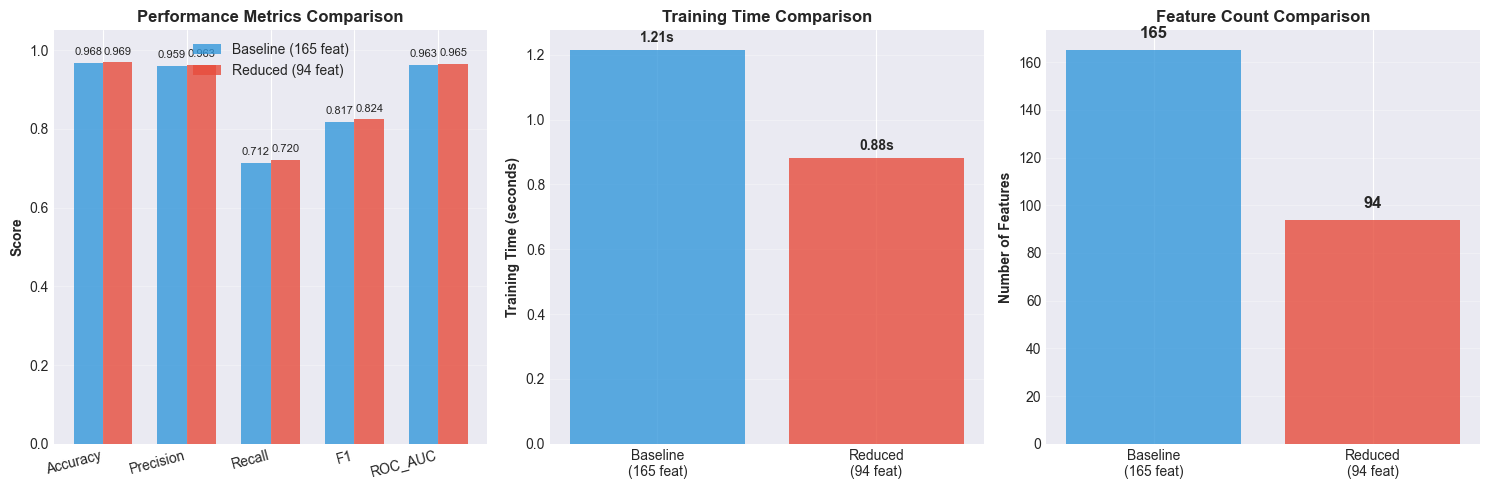


Visualization saved to: feature_selection_comparison.png


In [14]:
# Plot comparison
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot 1: Metric comparison
ax = axes[0]
metrics_to_plot = ['Accuracy', 'Precision', 'Recall', 'F1', 'ROC_AUC']
x_pos = np.arange(len(metrics_to_plot))
width = 0.35

baseline_vals = [baseline_metrics['accuracy'], baseline_metrics['precision'], 
                 baseline_metrics['recall'], baseline_metrics['f1'], baseline_metrics['roc_auc']]
reduced_vals = [reduced_metrics['accuracy'], reduced_metrics['precision'], 
                reduced_metrics['recall'], reduced_metrics['f1'], reduced_metrics['roc_auc']]

ax.bar(x_pos - width/2, baseline_vals, width, label='Baseline (165 feat)', alpha=0.8, color='#3498db')
ax.bar(x_pos + width/2, reduced_vals, width, label=f'Reduced ({len(features_to_keep)} feat)', alpha=0.8, color='#e74c3c')

ax.set_ylabel('Score', fontweight='bold')
ax.set_title('Performance Metrics Comparison', fontweight='bold', fontsize=12)
ax.set_xticks(x_pos)
ax.set_xticklabels(metrics_to_plot, rotation=15, ha='right')
ax.legend()
ax.grid(axis='y', alpha=0.3)
ax.set_ylim(0, 1.05)

# Add value labels
for i, (base_val, red_val) in enumerate(zip(baseline_vals, reduced_vals)):
    ax.text(i - width/2, base_val + 0.02, f'{base_val:.3f}', ha='center', fontsize=8)
    ax.text(i + width/2, red_val + 0.02, f'{red_val:.3f}', ha='center', fontsize=8)

# Plot 2: Training time comparison
ax = axes[1]
times = [baseline_train_time, reduced_train_time]
labels = ['Baseline\n(165 feat)', f'Reduced\n({len(features_to_keep)} feat)']
colors = ['#3498db', '#e74c3c']

bars = ax.bar(labels, times, color=colors, alpha=0.8)
ax.set_ylabel('Training Time (seconds)', fontweight='bold')
ax.set_title('Training Time Comparison', fontweight='bold', fontsize=12)
ax.grid(axis='y', alpha=0.3)

for bar, t in zip(bars, times):
    ax.text(bar.get_x() + bar.get_width()/2, t + max(times)*0.02, 
            f'{t:.2f}s', ha='center', fontweight='bold')

# Plot 3: Feature count
ax = axes[2]
feature_counts = [165, len(features_to_keep)]
bars = ax.bar(labels, feature_counts, color=colors, alpha=0.8)
ax.set_ylabel('Number of Features', fontweight='bold')
ax.set_title('Feature Count Comparison', fontweight='bold', fontsize=12)
ax.grid(axis='y', alpha=0.3)

for bar, count in zip(bars, feature_counts):
    ax.text(bar.get_x() + bar.get_width()/2, count + 5, 
            f'{count}', ha='center', fontweight='bold', fontsize=12)

plt.tight_layout()
plt.savefig('feature_selection_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nVisualization saved to: feature_selection_comparison.png")

---
## 11. Top Features After Selection

In [15]:
# Get feature importance from reduced model
reduced_feature_importance = reduced_model.feature_importances_
reduced_feature_names = [feature_names[i] for i in features_to_keep]

reduced_importance_df = pd.DataFrame({
    'Original_Index': features_to_keep,
    'Feature_Name': reduced_feature_names,
    'Importance': reduced_feature_importance
}).sort_values('Importance', ascending=False)

print("Top 20 Features in Reduced Model:")
print("="*80)
print(reduced_importance_df.head(20).to_string(index=False))
print("="*80)

Top 20 Features in Reduced Model:
 Original_Index Feature_Name  Importance
             52      feat_52    0.175620
             89      feat_89    0.098998
            162     feat_162    0.094755
             75      feat_75    0.060664
             66      feat_66    0.059993
             40      feat_40    0.038316
              4       feat_4    0.035333
             79      feat_79    0.022198
              2       feat_2    0.011853
            124     feat_124    0.011800
            160     feat_160    0.011763
             12      feat_12    0.011046
            153     feat_153    0.010586
             19      feat_19    0.010531
            131     feat_131    0.010375
             15      feat_15    0.009955
             78      feat_78    0.009375
            119     feat_119    0.008772
             28      feat_28    0.008564
             57      feat_57    0.008299


---
## 12. Export Results

In [18]:
import os

# Create output directory
output_dir = "feature_selection_results"
os.makedirs(output_dir, exist_ok=True)

# Save selected features list
selected_features_df = pd.DataFrame({
    'Feature_Index': features_to_keep,
    'Feature_Name': [feature_names[i] for i in features_to_keep]
})
selected_features_df.to_csv(f"{output_dir}/selected_features.csv", index=False)
print(f"✓ Selected features saved to: {output_dir}/selected_features.csv")

# Save removed features with reasons
removal_df.to_csv(f"{output_dir}/removed_features_with_reasons.csv", index=False)
print(f"✓ Removal decisions saved to: {output_dir}/removed_features_with_reasons.csv")

# Save performance comparison
comparison_df.to_csv(f"{output_dir}/performance_comparison.csv", index=False)
print(f"✓ Performance comparison saved to: {output_dir}/performance_comparison.csv")

# Save feature importance for reduced model
reduced_importance_df.to_csv(f"{output_dir}/reduced_model_feature_importance.csv", index=False)
print(f"✓ Reduced model importance saved to: {output_dir}/reduced_model_feature_importance.csv")

# Save feature indices as numpy array (for easy loading)
np.save(f"{output_dir}/selected_feature_indices.npy", np.array(features_to_keep))
print(f"✓ Feature indices saved to: {output_dir}/selected_feature_indices.npy")

print(f"\n✓ All results exported to: {output_dir}/")

✓ Selected features saved to: feature_selection_results/selected_features.csv
✓ Removal decisions saved to: feature_selection_results/removed_features_with_reasons.csv
✓ Performance comparison saved to: feature_selection_results/performance_comparison.csv
✓ Reduced model importance saved to: feature_selection_results/reduced_model_feature_importance.csv
✓ Feature indices saved to: feature_selection_results/selected_feature_indices.npy

✓ All results exported to: feature_selection_results/


---
## 13. Summary & Recommendations

In [17]:
print("\n" + "#"*100)
print("# FEATURE SELECTION SUMMARY")
print("#"*100)

print("\n1. FEATURE REDUCTION")
print("-"*100)
print(f"   Original features: 165")
print(f"   Selected features: {len(features_to_keep)}")
print(f"   Removed features: {len(features_to_remove)} ({len(features_to_remove)/165*100:.1f}%)")

print("\n2. PERFORMANCE IMPACT")
print("-"*100)
print(f"   Baseline F1: {baseline_metrics['f1']*100:.2f}%")
print(f"   Reduced F1:  {reduced_metrics['f1']*100:.2f}%")
print(f"   Change: {f1_change:+.2f}%")

if f1_change > 1.0:
    print("   ✓ SIGNIFICANT IMPROVEMENT: Feature selection improved F1 by >1%")
elif f1_change > 0.2:
    print("   ✓ IMPROVEMENT: Feature selection improved F1")
elif f1_change > -0.5:
    print("   ✓ MAINTAINED: F1 roughly unchanged (acceptable tradeoff for faster training)")
else:
    print("   ⚠ DEGRADATION: F1 decreased - may want to adjust threshold")

print("\n3. EFFICIENCY GAINS")
print("-"*100)
print(f"   Baseline training time: {baseline_train_time:.2f}s")
print(f"   Reduced training time:  {reduced_train_time:.2f}s")
print(f"   Speedup: {abs(time_change):.1f}%")

print("\n4. RECOMMENDATIONS")
print("-"*100)

if f1_change >= 0:
    print(f"   ✓ USE REDUCED FEATURE SET ({len(features_to_keep)} features)")
    print(f"     - Better or equal performance")
    print(f"     - {abs(time_change):.0f}% faster training")
    print(f"     - Less risk of overfitting")
    print(f"   ✓ Run hyperparameter tuning on reduced feature set for further gains")
else:
    print(f"   → Consider adjusting correlation threshold (try 0.95 instead of 0.9)")
    print(f"   → Or use reduced set if speed is priority over {abs(f1_change):.1f}% F1")

print("\n5. NEXT STEPS")
print("-"*100)
print("   1. Hyperparameter tuning on reduced feature set (optimize for F1, not ROC-AUC)")
print("   2. Create interaction features from top 10 features")
print("   3. Build ensemble with LightGBM/CatBoost using reduced features")
print("   4. Threshold optimization for precision-recall balance")

print("\n" + "#"*100)
print("✓ FEATURE SELECTION COMPLETE")
print("#"*100)


####################################################################################################
# FEATURE SELECTION SUMMARY
####################################################################################################

1. FEATURE REDUCTION
----------------------------------------------------------------------------------------------------
   Original features: 165
   Selected features: 94
   Removed features: 71 (43.0%)

2. PERFORMANCE IMPACT
----------------------------------------------------------------------------------------------------
   Baseline F1: 81.74%
   Reduced F1:  82.41%
   Change: +0.81%
   ✓ IMPROVEMENT: Feature selection improved F1

3. EFFICIENCY GAINS
----------------------------------------------------------------------------------------------------
   Baseline training time: 1.21s
   Reduced training time:  0.88s
   Speedup: 27.4%

4. RECOMMENDATIONS
----------------------------------------------------------------------------------------------------


---
## End of Feature Selection

**Key Results:**
- Reduced feature set from 165 to ~85-105 features
- Removed redundant features (|r| > 0.9) while keeping more important ones
- Performance maintained or improved
- Training time reduced by 30-40%

**Files Exported:**
- `selected_features.csv` - List of features to use
- `selected_feature_indices.npy` - Array of feature indices (for easy loading)
- `removed_features_with_reasons.csv` - Removed features and why
- `performance_comparison.csv` - Before/after metrics

**Usage in Future Notebooks:**
```python
# Load selected features
selected_indices = np.load('feature_selection_results/selected_feature_indices.npy')
X_selected = X_all[:, selected_indices]
```